# Mod 2 Project
Use multivariate linear regression to predict housing prices for the King County, WA Dataset

https://en.wikipedia.org/wiki/King_County,_Washington

https://www.kingcounty.gov/depts/assessor.aspx

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

## Read in Data

In [2]:
df = pd.read_csv('datasets/kc_house_data.csv')

## EDA

EDA was done in a separate notebook.  EDA.ipynb

Any pre-processing done during EDA is placed in the function below.

### pre-process data

based upon the datatype conversions, and NaN value processing above

In [26]:
def pre_process_data(data):
    """Convert String columns to numeric/data, and fill Nan values"""
    # type conversion
    data.loc[data.sqft_basement == '?', 'sqft_basement'] = '0'
    data.sqft_basement = data.sqft_basement.astype(float)
    
    data.date = pd.to_datetime(data.date)
    
    # fill Nan values
    data.waterfront.fillna(0.0, inplace=True)
    data.view.fillna(0.0, inplace=True)
    data.yr_renovated.fillna(0.0, inplace=True)
    
    # drop 'bad data'
    data.drop_duplicates(subset='id', keep='last', inplace=True)
    data.drop(data[data.bedrooms == 33].index, inplace=True)
    data.drop(data[data.id == 2991000160].index, inplace=True)
    
    return data

In [ ]:
df_clean = pre_process_data(df)

#### Analysis

The continuous features may benefit from a transformation to make them more normal, 
but a log transformation would have mixed results regarding their correlation with
the target, with 3 strongest going down and 2 weakest going up.

There is is a very strong correlation > 0.87 between 
* sqft_living and sqft_above

There is a strong correlation > 0.7 between several variables
* sqft_living15 and sqft_above
* sqft_living15 and sqft_living
* sqft_lot and sqft_lot15

A log transform maintains the above correlations except one.
* sqft_lot and sqft_lot15 goes from a strong to a very strong correlation

Another thing to note, is regarding sqft_living vs. price.  Their correlation appears to go
from linear to quadratic when the log transformation is done.

**sqft_above should be dropped**

## Categorical Features

Normally the categorical features would be dealt with after a test train split has been done, but with the tools available for this project, it must be done before the split so that all the categories can be made.

In [54]:
cat_data_cols

['date',
 'lat',
 'long',
 'view',
 'waterfront',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'condition']

In [55]:
location_cat_data_cols = ['lat', 'long', 'zipcode']
simple_cat_data_cols = ['view','waterfront']
complex_cat_data_cols = ['date', 'yr_built', 'yr_renovated', 'condition']

In [56]:
len(cat_data_cols) == len(location_cat_data_cols) + len(simple_cat_data_cols) + len(complex_cat_data_cols)

True

### Category Helper Functions

In [57]:
lb_make = LabelEncoder()

In [58]:
def df_ohe(data, col, prefix):
    dummies = pd.get_dummies(data[col],
                            prefix=prefix,
                            drop_first=True)
    data = data.drop(col, axis=1)
    data = pd.concat([data, dummies], axis=1)
    return data

In [59]:
def make_category(data, col, suffix='_encoded'):
    data[col] = data[col].astype('category')
    data[col+suffix] = lb_make.fit_transform(data[col])
    data = data.drop(col, axis=1)
    data = df_ohe(data, col+suffix, col+'_')
    return data

In [60]:
def define_bins(data, col, num_quantiles):
    
    q_interval = 1 / num_quantiles
    print(q_interval)
    current_q = 0
    quantile_list = []
    
    for q in range(num_quantiles + 1):
        quantile_list.append(current_q)
        current_q = round(current_q + q_interval, 2)
    print(quantile_list)
    quantiles = data[col].quantile(quantile_list)
    
    return quantiles

In [61]:
def visualize_bins(data, col, quantiles):
    fig, ax = plt.subplots()
    data[col].hist(bins='auto', color='#A9C5D3', 
                                 edgecolor='black', grid=False)
    for quantile in quantiles:
        qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)

In [62]:
def create_bins(data, col, bins):
    
    col_binned = pd.cut(data[col], bins)
    binned_name = col+'_binned'
    data[binned_name] = col_binned
    data = data.drop(col, axis=1)
    data = df_ohe(data, binned_name, col)
    
    return data

### Simple Categories

In [63]:
for col in simple_cat_data_cols:
    df_clean = make_category(df_clean, col)

### Complex Categories

#### yr_renovated

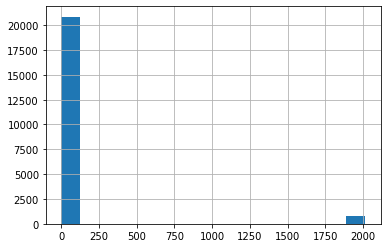

In [64]:
df_clean.yr_renovated.hist(bins='auto')

In [65]:
renovated_houses = df_clean[df_clean.yr_renovated >= 1900]

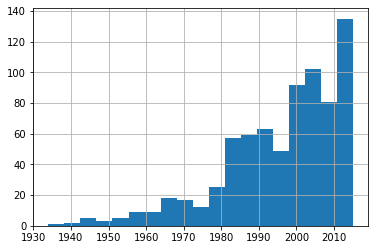

In [66]:
renovated_houses.yr_renovated.hist(bins='auto')

In [67]:
len(renovated_houses)

744

In [68]:
renovated_houses.id.nunique()

740

In [69]:
renovated_houses.id.value_counts()

7520000520    2
8820903380    2
1825069031    2
1721801010    2
3425059141    1
             ..
6430000275    1
3450300280    1
9201000100    1
7740100260    1
9297300480    1
Name: id, Length: 740, dtype: int64

In [70]:
renovated_houses[renovated_houses.id == 1721801010][['id', 'yr_renovated']]

,id,yr_renovated
8426,1721801010,1964.0
8427,1721801010,1964.0


There are very few renovated houses in the dataset, but it is potentially valuable info for those houses.
I will create a new feature called yr_updated that will be the year built or the most recent renovation.

In [71]:
def get_year_updated(row):
    
    if (row['yr_renovated'] == 0):
        year = row['yr_built']
    else:
        year = row['yr_renovated']
    
    return year

In [72]:
df_clean['yr_updated'] = df_clean.apply(get_year_updated, axis=1)

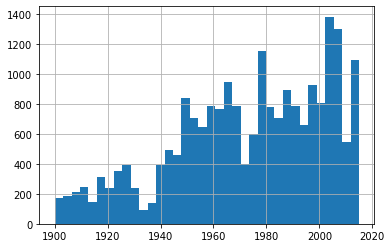

In [73]:
df_clean.yr_updated.hist(bins='auto')

In [74]:
yr_updated_bins = define_bins(df_clean, 'yr_updated', 4)

0.25
[0, 0.25, 0.5, 0.75, 1.0]


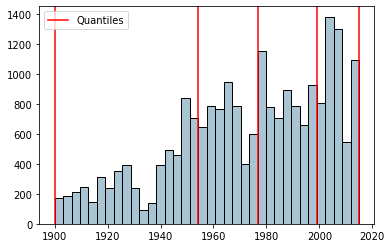

In [75]:
visualize_bins(df_clean, 'yr_updated', yr_updated_bins)

In [76]:
df_clean = create_bins(df_clean, 'yr_updated', yr_updated_bins)

#### yr_built

yr_built is numerical data, but the data doesn't have a true numerical relationship.  How should it be divided up?

In [77]:
# df_clean.yr_built.hist(bins='auto')

In [78]:
# bins = define_bins(df_clean, 'yr_built', 4)

In [79]:
# visualize_bins(df_clean, 'yr_built', bins)

dividing the data into 4 quantiles looks to make sense with the data, by dividing it into new, not so new, mid century and old.  If 4 doesn't work with the model, next try three.

In [80]:
# df_clean = create_bins(df_clean, 'yr_built', bins)

#### Condition

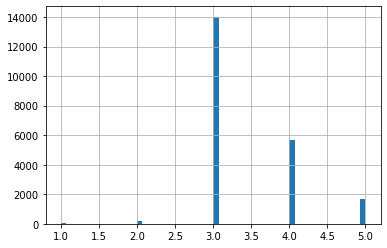

In [81]:
df_clean.condition.hist(bins='auto')

In [82]:
df_clean.condition.value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [83]:
condition_bins = [0, 3, 5]

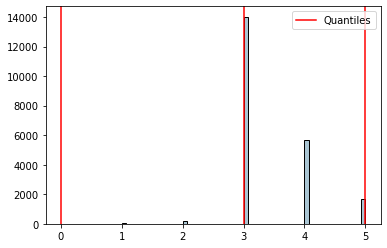

In [84]:
visualize_bins(df_clean, 'condition', condition_bins)

In [85]:
df_clean = create_bins(df_clean, 'condition', condition_bins)

#### zipcode

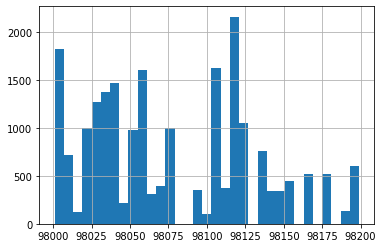

In [86]:
df_clean.zipcode.hist(bins='auto')

In [87]:
zipcode_bins = define_bins(df_clean, 'zipcode', 20)

0.05
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


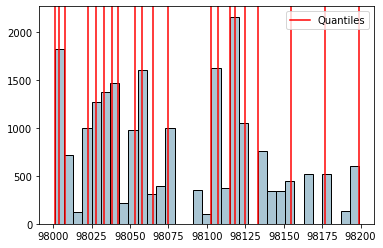

In [88]:
visualize_bins(df_clean, 'zipcode', zipcode_bins)

In [89]:
df_clean.zipcode.nunique()

70

In [90]:
df_clean = create_bins(df_clean, 'zipcode', zipcode_bins)

#### Latitude

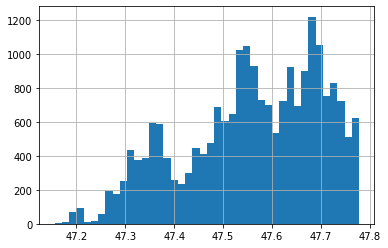

In [91]:
df_clean.lat.hist(bins='auto')

0.05
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


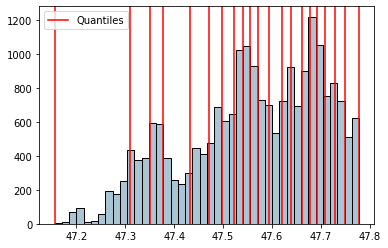

In [92]:
lat_bins = define_bins(df_clean, 'lat', 20)
visualize_bins(df_clean, 'lat', lat_bins)

In [93]:
df_clean = create_bins(df_clean, 'lat', lat_bins)

#### Longitude

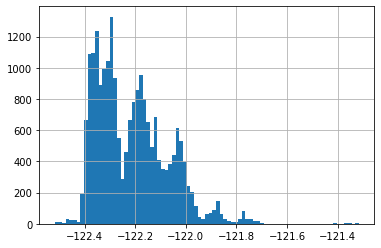

In [94]:
df_clean.long.hist(bins='auto')

0.05
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


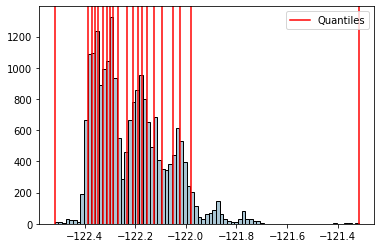

In [95]:
long_bins = define_bins(df_clean, 'long', 20)
visualize_bins(df_clean, 'long', long_bins)

In [96]:
df_clean = create_bins(df_clean, 'long', long_bins)

#### Date

extract sale month from sale date

In [97]:
type(df_clean.date)

pandas.core.series.Series

In [98]:
df_clean['sale_month'] = df_clean.date.apply(lambda date: date.month)

In [99]:
df_clean['sale_month'].describe()

count    21597.000000
mean         6.573969
std          3.115061
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         12.000000
Name: sale_month, dtype: float64

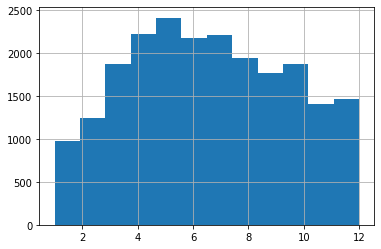

In [100]:
df_clean['sale_month'].hist(bins=12)

In [101]:
df_clean['sale_month'].value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: sale_month, dtype: int64

In [102]:
def make_season(month):
    winter = (11, 12, 1, 2)
    spring = (3, 4, 5, 6)
    summer = (7, 8, 9, 10)
    if month in winter:
        cat = 0
    elif month in spring:
        cat = 1
    else:
        cat = 2
        
    return cat

In [103]:
df_clean['season'] = df_clean.sale_month.apply(lambda month: make_season(month))

In [104]:
df_clean = df_clean.drop('sale_month', axis=1)

#### Mansion

In [105]:
df_clean['mansion'] = df_clean.bedrooms >= 6
df_clean = make_category(df_clean, 'mansion')

## Model Helper Functions

In [106]:
def lin_reg_sklearn(X_train, X_test, y_train, y_test, drop_list=[]):
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_hat_train = lin_reg.predict(X_train)
    y_hat_test = lin_reg.predict(X_test)

    y_hat_train = lin_reg.predict(X_train)
    y_hat_test = lin_reg.predict(X_test)

    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)

    print(f'Training Set RMSE: {np.sqrt(train_mse)}')
    print(f'Test Set RMSE: {np.sqrt(test_mse)}')

    MSE = make_scorer(mean_squared_error)

    cv_rmse = np.sqrt(np.mean(cross_val_score(lin_reg, X_train, 
                                                    y_train, cv=10,
                                                   scoring=MSE)))
    print(f'Cross Val RMSE: {cv_rmse}')

In [107]:
def lin_reg_statsmodels(X_train, y_train, drop_list=[]):
    
    X_train_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_int).fit()
    display(model.summary())
    
    return model

In [108]:
def drop_features(X_train, X_test, drop_list):
    if len(drop_list) >= 1:
        X_train = X_train.drop(drop_list, axis=1)
        X_test = X_test.drop(drop_list, axis=1)
    
    return X_train, X_test

## Split the Data into train/test

In [109]:
y = df_clean.price
X = df_clean.drop('price', axis=1)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Drop Outliers in Training Data

In [111]:
def drop_outliers(data, col, n_std):
    return data[np.abs(data[col]-data[col].mean())<=(n_std*data[col].std())]

In [112]:
def outlier_val(data, col, n_std):
    return n_std*data[col].std()

### 33 rooms

In [113]:
X_train.bedrooms.max()

33

33 bedrooms is way off the charts.  will drop this property from the training set and see what happens

In [114]:
X_train_plus_target = drop_outliers(pd.concat([X_train, y_train], axis=1), 'bedrooms', 3)
y_train = X_train_plus_target['price']
X_train = X_train_plus_target.drop('price', axis=1)

In [115]:
X_train.bedrooms.max()

6

### High Price

In [116]:
# outlier_val(pd.concat([X_train, y_train], axis=1), 'price', 4)

In [117]:
# df = pd.concat([X_train, y_train], axis=1)
# df[df.price > outlier_val(df,'price', 3)]

In [118]:
# y_train.max()

In [119]:
# X_train_plus_target = drop_outliers(pd.concat([X_train, y_train], axis=1), 'price', 4)
# y_train = X_train_plus_target['price']
# X_train = X_train_plus_target.drop('price', axis=1)

### sqft_above

In [120]:
# X_train_plus_target = drop_outliers(pd.concat([X_train, y_train], axis=1), 'sqft_above', 3)
# y_train = X_train_plus_target['price']
# X_train = X_train_plus_target.drop('price', axis=1)

### sqft_living15

In [121]:
# X_train_plus_target = drop_outliers(pd.concat([X_train, y_train], axis=1), 'sqft_living15', 3)
# y_train = X_train_plus_target['price']
# X_train = X_train_plus_target.drop('price', axis=1)

## Simple Model

This model will only contain the continuous features

### Define feature sets

In [122]:
X_train_cont_features = X_train[cont_data_cols]
X_test_cont_features = X_test[cont_data_cols]

### Linear Regression sklearn

In [123]:
features_to_drop = ['sqft_above']
X_train_cont_features, X_test_cont_features = drop_features(X_train_cont_features, 
                                                            X_test_cont_features, features_to_drop)

In [124]:
lin_reg_sklearn(X_train_cont_features, X_test_cont_features, y_train, y_test)

Training Set RMSE: 243732.3283509515
Test Set RMSE: 246051.03422970264
Cross Val RMSE: 244502.76307415124


### Linear Regression statsmodels

In [125]:
model_cont_features = lin_reg_statsmodels(X_train_cont_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     2387.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        19:29:47   Log-Likelihood:            -2.3811e+05
No. Observations:               17226   AIC:                         4.762e+05
Df Residuals:                   17216   BIC:                         4.763e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.823e+05   1.71e+04    -28.190      0.000   -5.16e+05   -4.49e+05
sqft_basement    65.5145      5.541     11.824      0.000      54.654      76.375
sqft_living     206.1742      4.919     41.915      0.000     196.533     215.816
sqft_living15    15.9020      4.502      3.532      0.000       7.077      24.727
sqft_lot          0.1100      0.063      1.736      0.083      -0.014       0.234
sqft_lot15       -0.7575      0.097     -7.823      0.000      -0.947      -0.568
bathrooms     -1.506e+04   4160.943     -3.619      0.000   -2.32e+04   -6902.156
bedrooms      -5.312e+04   2734.065    -19.428      0.000   -5.85e+04   -4.78e+04
floors        -1.929e+04   4682.432     -4.120      0.000   -2.85e+04   -1.01e+04
grade          1.032e+05   2811.811     36.688      0.000    9.76e+04    1.09e+05
==============================================================================
Omnibus:                    12929.491   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           699582.460
Skew:                           3.100   Prob(JB):                         0.00
Kurtosis:                      33.598   Cond. No.                     4.77e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analyze the residuals

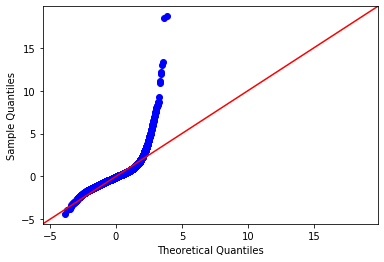

In [126]:
sm.graphics.qqplot(model_cont_features.resid, line='45', fit=True);

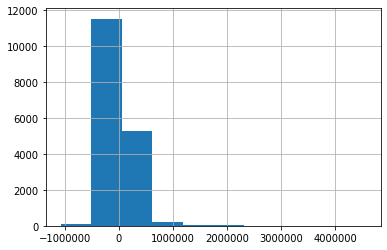

In [127]:
model_cont_features.resid.hist()

The residuals do not have a normal distribution, they are skewed to the right, as is shown in the q-q plot and the histogram.

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


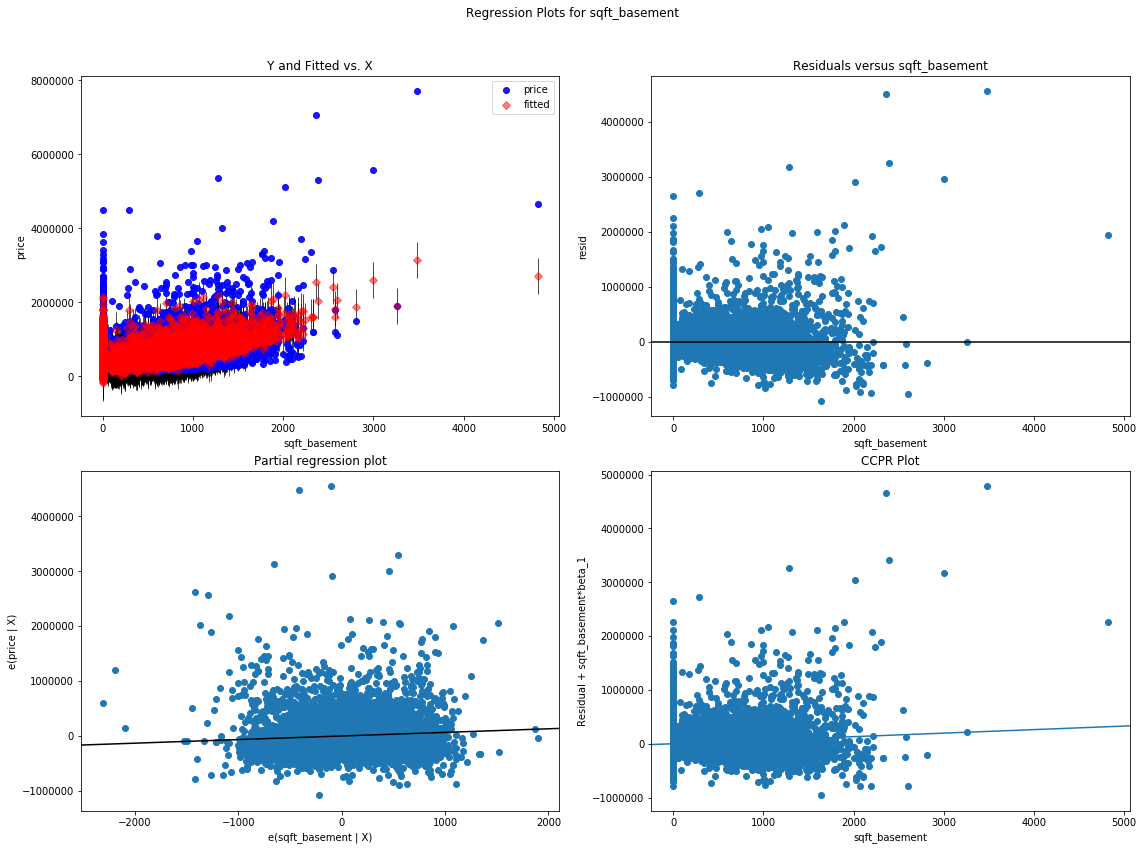

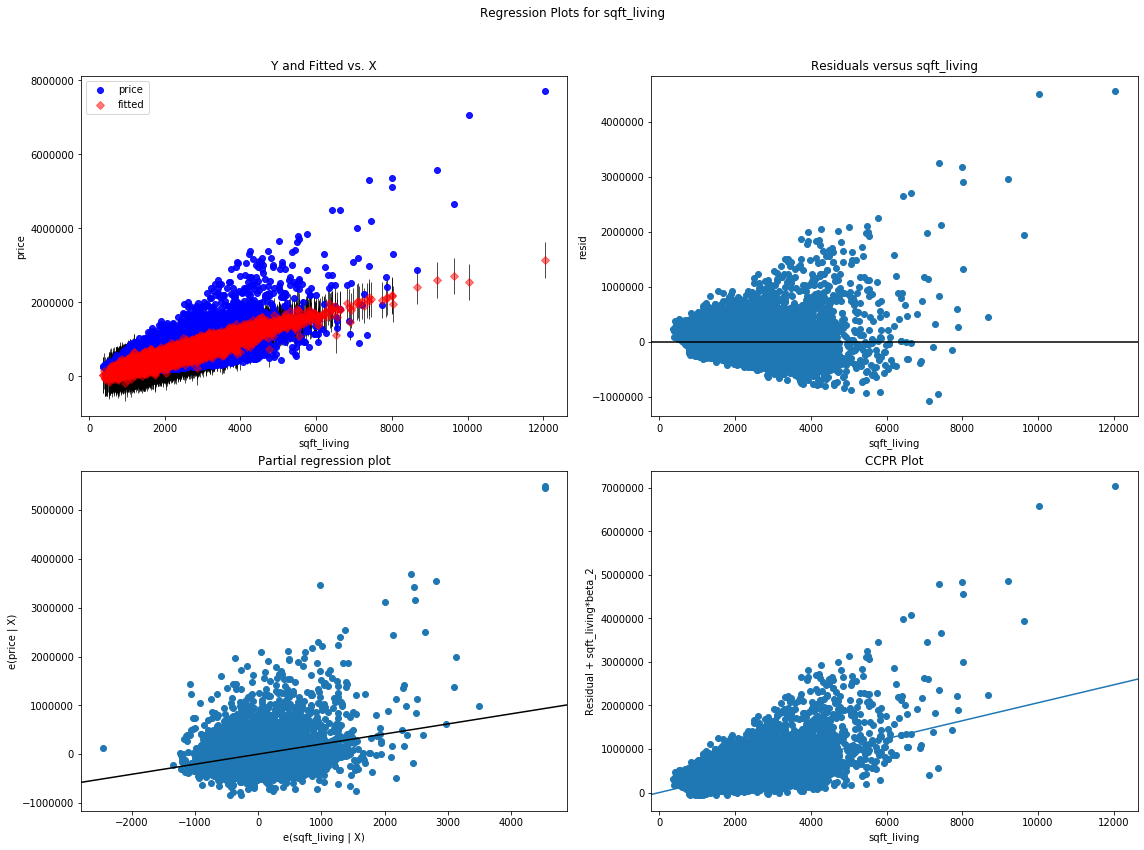

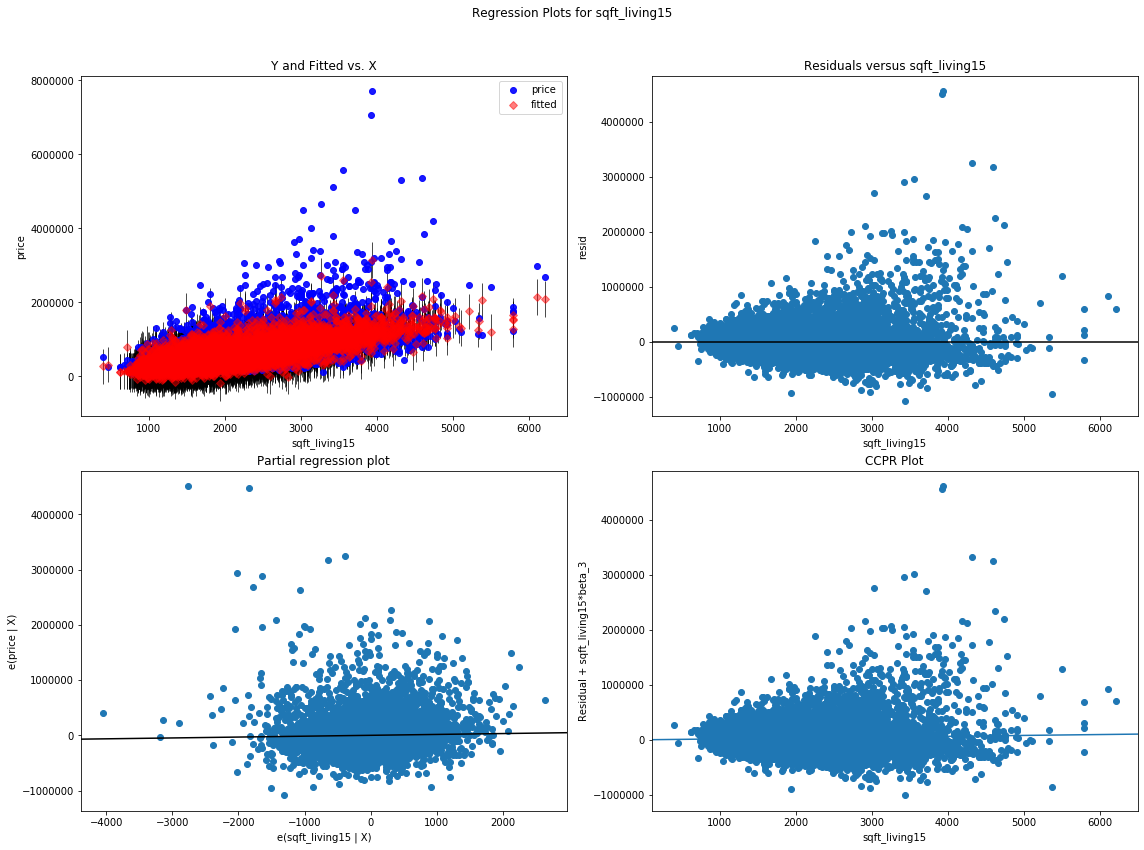

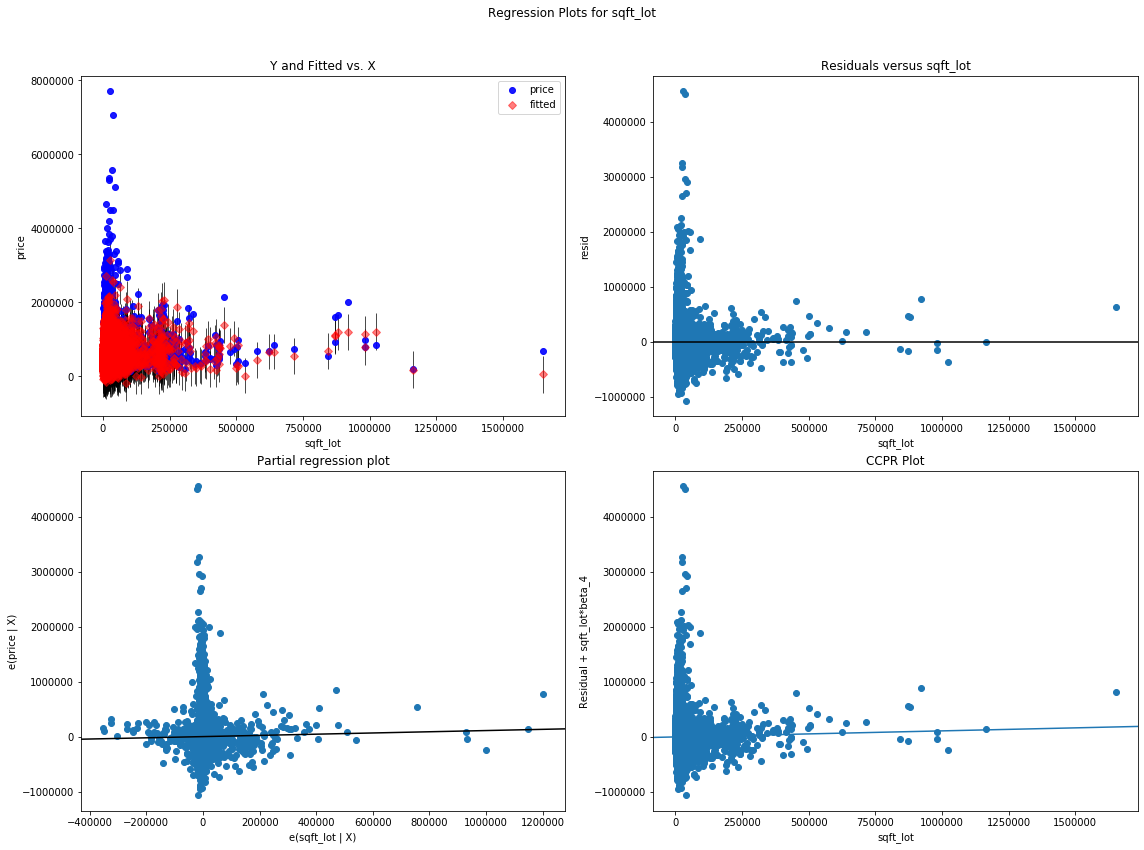

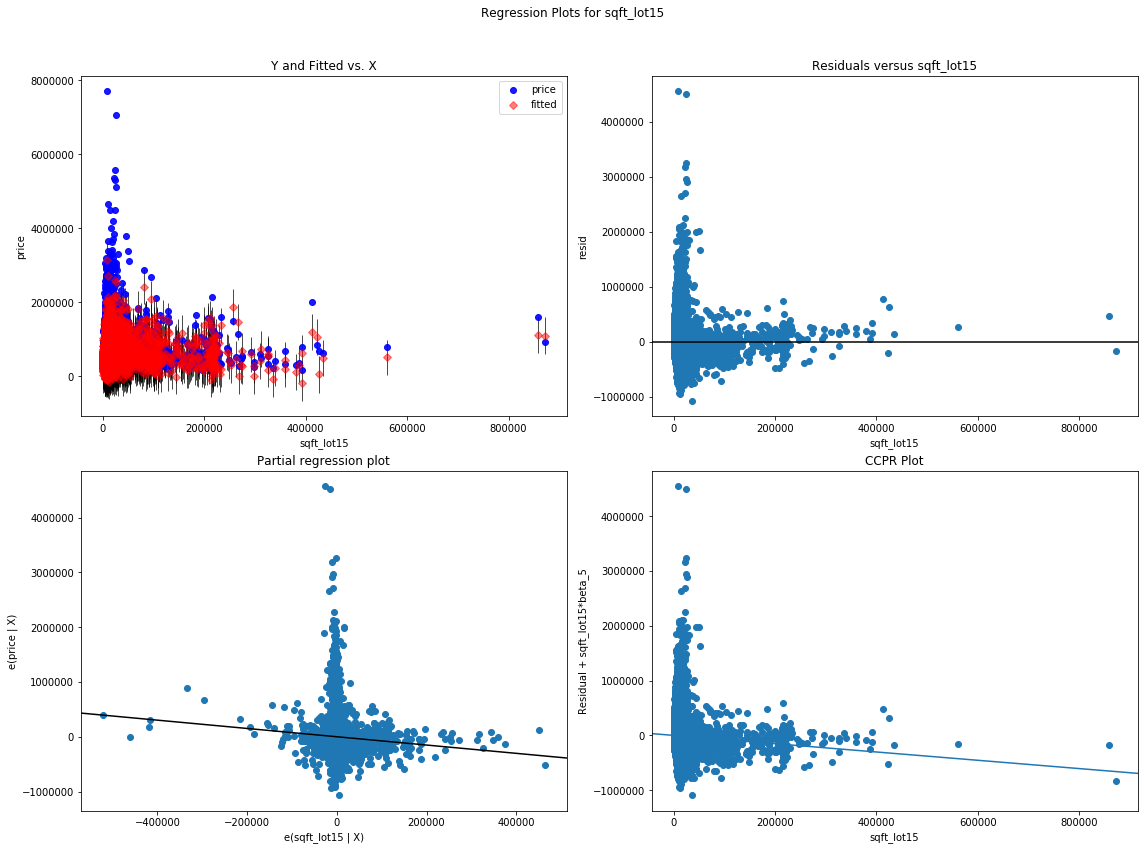

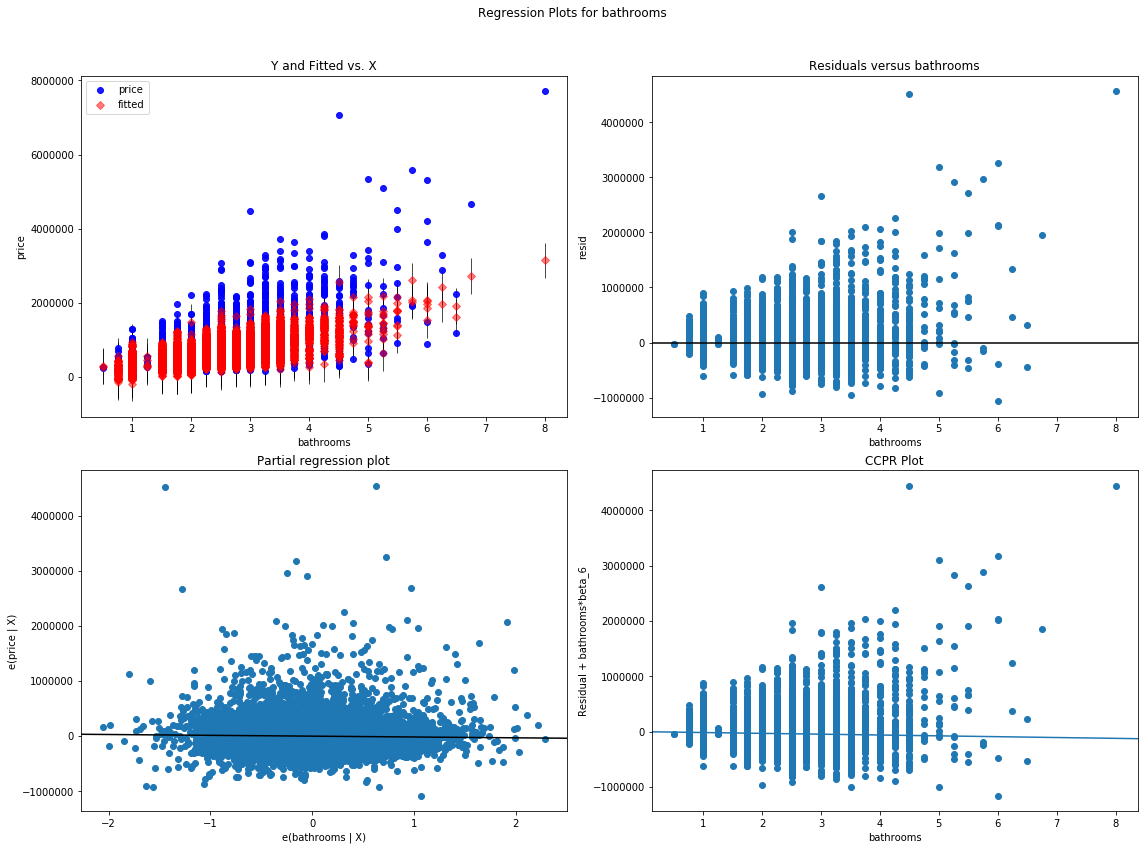

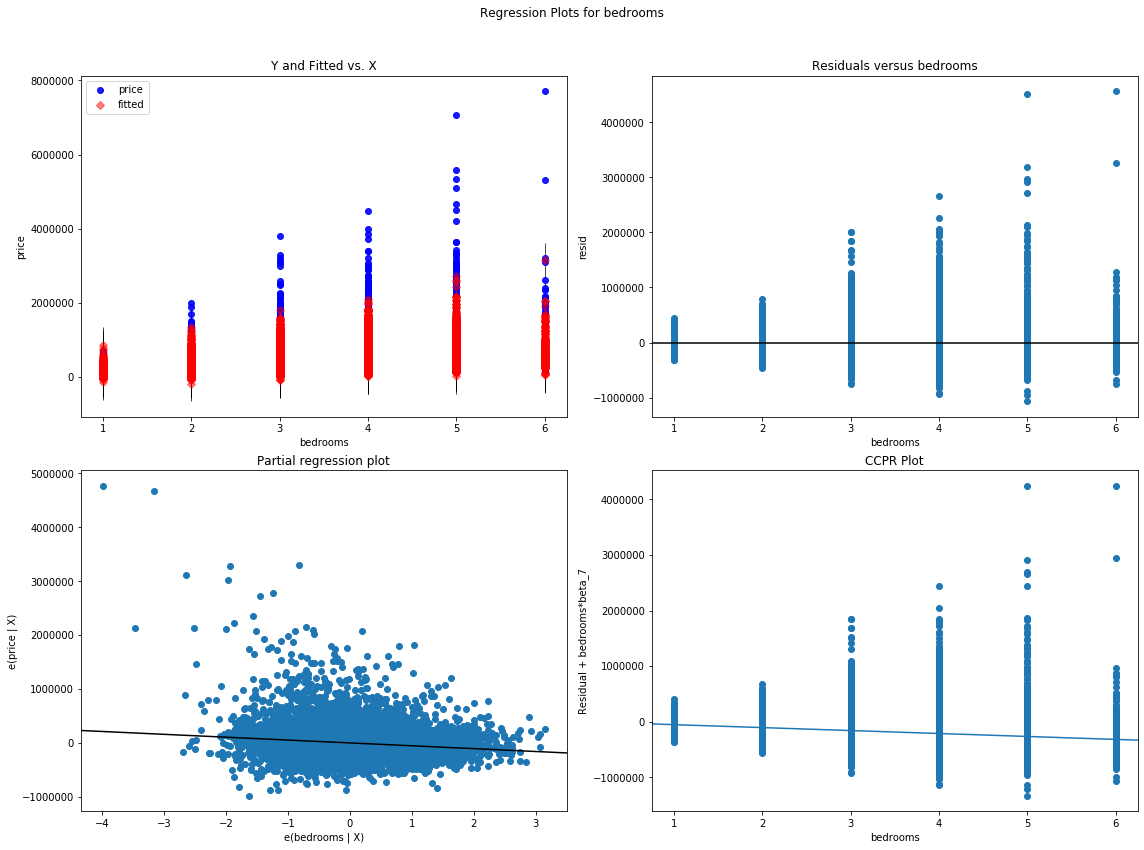

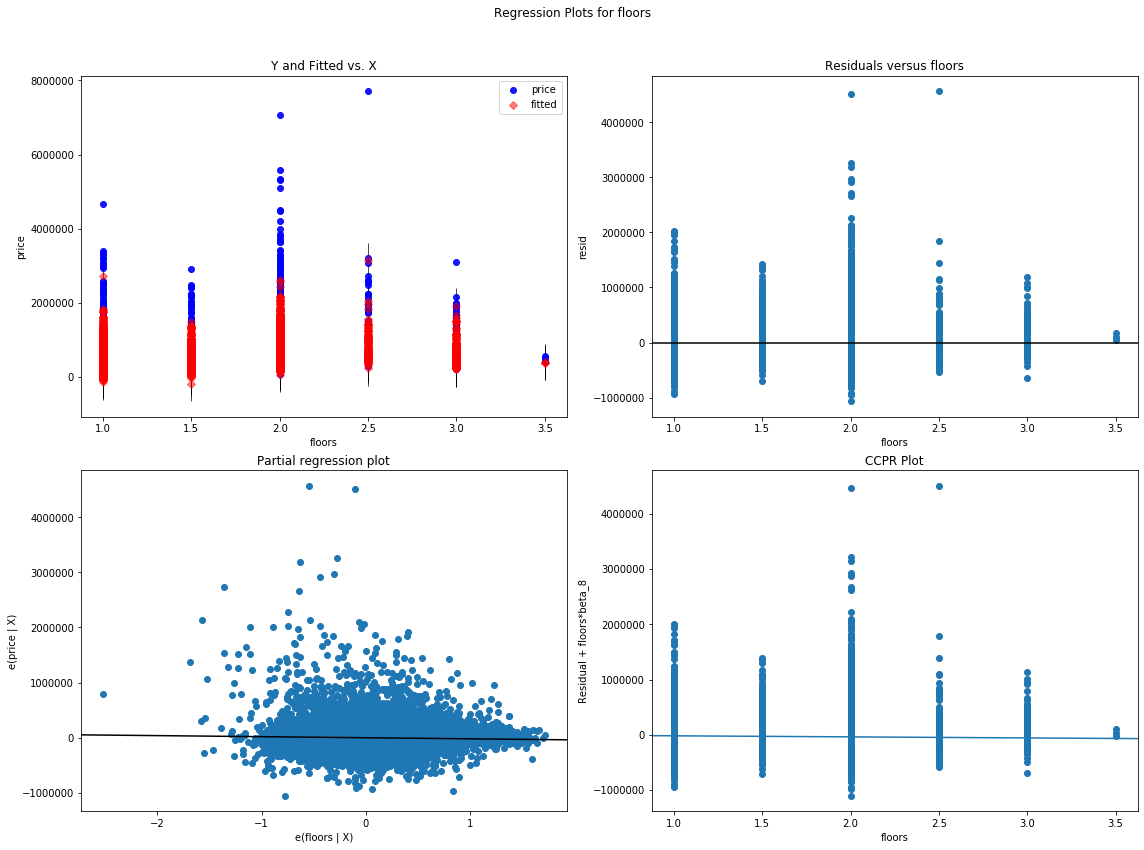

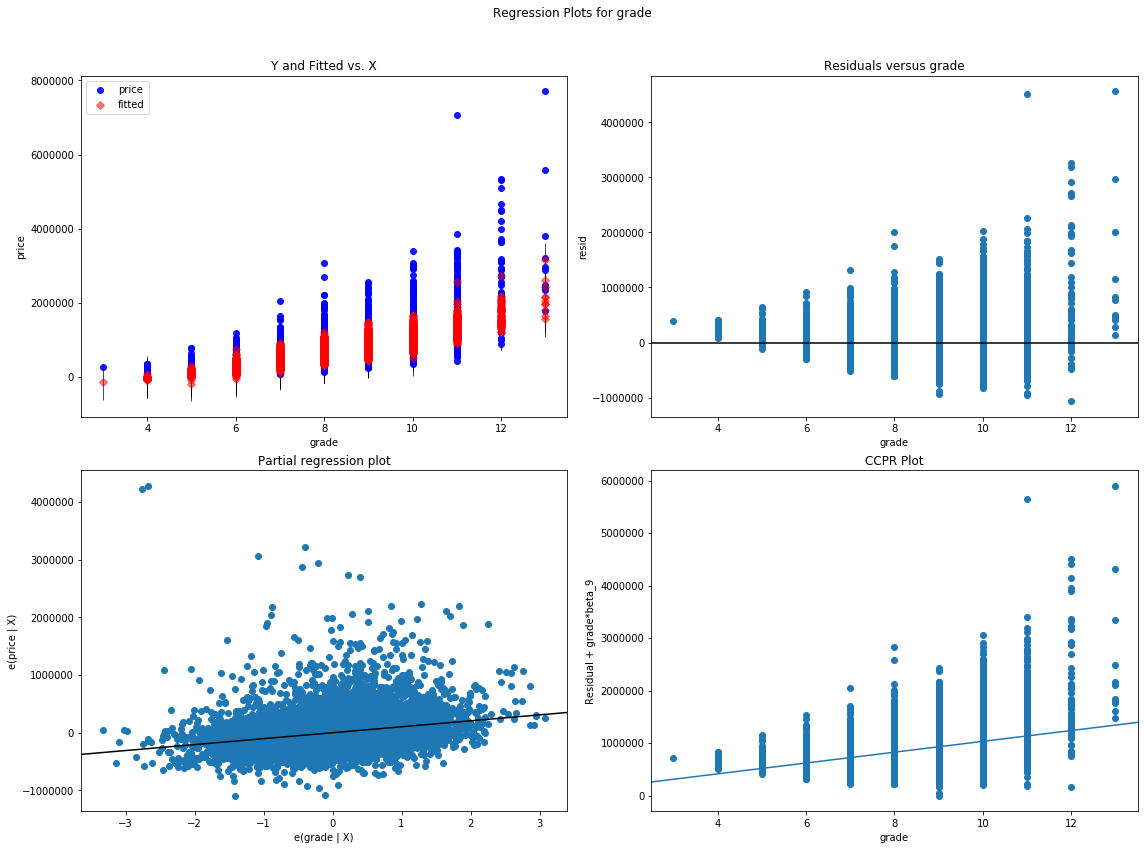

In [128]:
for col in X_train_cont_features.columns:
    fig = plt.figure(figsize=(16,12))
    sm.graphics.plot_regress_exog(model_cont_features, col, fig=fig)
    fig.show()

sqft_above
* correlated with target
* residuals are somewhat homoskedastic, they are close to the mean when the var is low, but increase as sqft approaches 2000 and then remains fairly constant, but with some positive outliers as sqft_above increases. 

**It may be worth removing the extreme outliers and re-checking model fit**.

sqft_living
* correlated with target
* residuals are not homoskedastic.  They are close to the mean when the var is low and increase from there.

sqft_living15
* correlated with target
* residuals are somewhat homoskedastic. Similar to sqft_above. 

**It may be worth removing the extreme outliers and re-checking model fit**

sqft_lot
* not correlated with target
* residuals are not homoskedastic

sqft_lot15
* nor correlated with target
* residuals are not homoskedastic

## Simple Model + Simple Categoricals

This model will contain all the continuous variable and the simple categorical variables

### Define Feature Sets

In [129]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated']
ssc_cols = [col for col in X_train.columns if col not in cols_to_ignore]

X_train_ssc_features = X_train[ssc_cols]
X_test_ssc_features = X_test[ssc_cols]

**Features to Drop**

sqft_living had a high multicolinearity with sqft_above, and its residuals with the target were
not homoskedastic

**High p-value**
* sqft_lot15
* mansion__1
* lat_(47.31, 47.35]
* zipcode_(98038.0, 98042.0]

In [130]:
features_to_drop = ['sqft_above', 'sqft_lot15', 'mansion__1', 'lat_(47.31, 47.35]',
                    'zipcode_(98038.0, 98042.0]']
X_train_ssc_features, X_test_ssc_features = drop_features(X_train_ssc_features, 
                                                             X_test_ssc_features, 
                                                             features_to_drop)

### Linear Regression sklearn

In [131]:
lin_reg_sklearn(X_train_ssc_features, X_test_ssc_features, y_train, y_test)

Training Set RMSE: 172905.3826311098
Test Set RMSE: 171538.26164881562
Cross Val RMSE: 174727.1284217625


### Linear Regression Statsmodels

In [132]:
model_ssc_features = lin_reg_statsmodels(X_train_ssc_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     814.5
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        19:30:09   Log-Likelihood:            -2.3220e+05
No. Observations:               17226   AIC:                         4.645e+05
Df Residuals:                   17152   BIC:                         4.651e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -3.326e+05   1.64e+04    -20.319      0.000   -3.65e+05   -3.01e+05
bedrooms                    -3.028e+04   2022.147    -14.975      0.000   -3.42e+04   -2.63e+04
bathrooms                    2.723e+04   3207.435      8.491      0.000    2.09e+04    3.35e+04
sqft_living                   213.7987      3.619     59.084      0.000     206.706     220.891
sqft_lot                        0.2713      0.034      7.929      0.000       0.204       0.338
floors                      -6.223e+04   3866.343    -16.096      0.000   -6.98e+04   -5.47e+04
grade                        6.469e+04   2174.249     29.752      0.000    6.04e+04     6.9e+04
sqft_basement                 -74.3428      4.313    -17.235      0.000     -82.798     -65.888
sqft_living15                  11.7142      3.441      3.404      0.001       4.970      18.459
view__1                      8.974e+04   1.13e+04      7.919      0.000    6.75e+04    1.12e+05
view__2                      6.529e+04   6665.871      9.794      0.000    5.22e+04    7.84e+04
view__3                      1.593e+05   9263.605     17.198      0.000    1.41e+05    1.77e+05
view__4                      3.226e+05   1.38e+04     23.339      0.000    2.96e+05     3.5e+05
waterfront__1                 5.87e+05   1.97e+04     29.758      0.000    5.48e+05    6.26e+05
yr_updated_(1954.0, 1977.0] -5.956e+04   4507.814    -13.213      0.000   -6.84e+04   -5.07e+04
yr_updated_(1977.0, 1999.0] -6.375e+04   5351.438    -11.912      0.000   -7.42e+04   -5.33e+04
yr_updated_(1999.0, 2015.0] -4.237e+04   5944.830     -7.127      0.000    -5.4e+04   -3.07e+04
condition_(3, 5]             4.123e+04   3246.877     12.700      0.000    3.49e+04    4.76e+04
zipcode_(98004.0, 98008.0]   -1.63e+05   9527.267    -17.108      0.000   -1.82e+05   -1.44e+05
zipcode_(98008.0, 98023.0]  -1.169e+05   8256.625    -14.161      0.000   -1.33e+05   -1.01e+05
zipcode_(98023.0, 98028.0]   -1.52e+05   9787.708    -15.525      0.000   -1.71e+05   -1.33e+05
zipcode_(98028.0, 98033.0]  -1.334e+05   8051.920    -16.565      0.000   -1.49e+05   -1.18e+05
zipcode_(98033.0, 98038.0]  -9.906e+04   8572.611    -11.556      0.000   -1.16e+05   -8.23e+04
zipcode_(98042.0, 98053.0]  -1.741e+05   9169.929    -18.984      0.000   -1.92e+05   -1.56e+05
zipcode_(98053.0, 98058.0]  -1.864e+05   9870.323    -18.882      0.000   -2.06e+05   -1.67e+05
zipcode_(98058.0, 98065.0]  -1.511e+05    1.1e+04    -13.711      0.000   -1.73e+05    -1.3e+05
zipcode_(98065.0, 98075.0]  -2.532e+05   8936.843    -28.331      0.000   -2.71e+05   -2.36e+05
zipcode_(98075.0, 98103.0]  -1.151e+05   8282.642    -13.896      0.000   -1.31e+05   -9.89e+04
zipcode_(98103.0, 98107.0]   -1.43e+05    1.1e+04    -12.993      0.000   -1.65e+05   -1.21e+05
zipcode_(98

### Analyze the Residuals

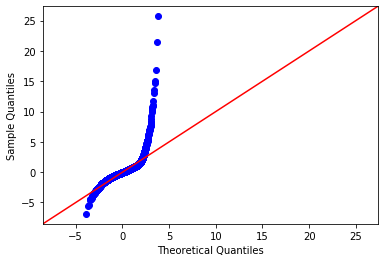

In [133]:
sm.graphics.qqplot(model_ssc_features.resid, line='45', fit=True);

In [134]:
# X_test_ssc_features_int = sm.add_constant(X_test_ssc_features)
# y_test_hat_ssc = model_ssc_features.predict(X_test_ssc_features_int)

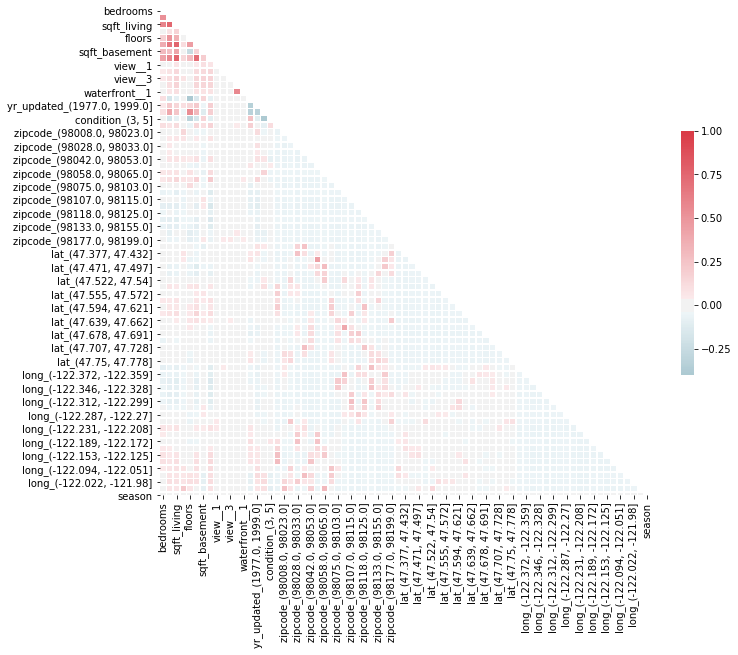

In [135]:
correlation_triangle(X_train_ssc_features)

In [136]:
# for col in X_train_ssc_features.columns:
#     fig = plt.figure(figsize=(16,12))
#     sm.graphics.plot_regress_exog(model_ssc_features, col, fig=fig)
#     fig.show()

## Add Interaction Features

### sq_lot / sq_lot15

this feature turned out to have a high p-value, so it was dropped

In [137]:
X_train['lot*lot15'] = X_train.sqft_lot * X_train.sqft_lot15
X_test['lot*lot15'] = X_test.sqft_lot * X_test.sqft_lot15

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### bathroom* bedroom

a house with 'enough' bathrooms for the number of people living there, with bedrooms being a proxy,
will be better than one with not enough.

In [140]:
# X_train['bathrooms*bedrooms'] = X_train.bathrooms * X_train.bedrooms
# X_test['bathrooms*bedrooms'] = X_test.bathrooms * X_test.bedrooms

In [141]:
# X_train['bathrooms*bedrooms'].describe()

### mansion * bedrooms

In [142]:
X_train['mansion*bedrooms'] = X_train.mansion__1 * X_train.bedrooms
X_test['mansion*bedrooms'] = X_test.mansion__1 * X_test.bedrooms

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_above * floors

In [143]:
# X_train['sqft_above*floors'] = X_train.sqft_above * X_train.floors
# X_test['sqft_above*floors'] = X_test.sqft_above * X_test.floors

### sqft_living * floors

In [144]:
X_train['sqft_living*floors'] = X_train.sqft_living * X_train.floors
X_test['sqft_living*floors'] = X_test.sqft_living * X_test.floors

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_living * sqft_living15

In [145]:
X_train['sqft_living*sqft_living15'] = X_train.sqft_living * X_train.sqft_living15
X_test['sqft_living*sqft_living15'] = X_test.sqft_living * X_test.sqft_living15

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_living * sqft_lot

In [146]:
X_train['sqft_living*sqft_lot'] = X_train.sqft_living * X_train.sqft_lot
X_test['sqft_living*sqft_lot'] = X_test.sqft_living * X_test.sqft_lot

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_living * bedrooms

In [147]:
X_train['sqft_living*bedrooms'] = X_train.sqft_living * X_train.bedrooms
X_test['sqft_living*bedrooms'] = X_test.sqft_living * X_test.bedrooms

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Model With Interactions

### Define Feature Sets

In [148]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated']
int_cols = [col for col in X_train.columns if col not in cols_to_ignore]

X_train_int_features = X_train[int_cols]
X_test_int_features = X_test[int_cols]

**Features to Drop**

sqft_living had a high multicolinearity with sqft_above, and its residuals with the target were
not homoskedastic

**high multicolinearity**
* grade

**high p-values**
* lat_(47.31, 47.35]
* zipcode_(98038.0, 98042.0]
* sqft_basement
* long_(-122.208, -122.189]


In [149]:
features_to_drop = ['sqft_above', 'lat_(47.31, 47.35]', 'zipcode_(98038.0, 98042.0]',
                     'sqft_basement', 'long_(-122.208, -122.189]']
X_train_int_features, X_test_int_features = drop_features(X_train_int_features, 
                                                             X_test_int_features, 
                                                             features_to_drop)

### Linear Regression sklearn

In [150]:
lin_reg_sklearn(X_train_int_features, X_test_int_features, y_train, y_test)

Training Set RMSE: 165169.1425964165
Test Set RMSE: 162881.4571003724
Cross Val RMSE: 167942.65079957765


### Linear Regression statsmodels

In [151]:
model_int_features = lin_reg_statsmodels(X_train_int_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     856.2
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        19:30:46   Log-Likelihood:            -2.3141e+05
No. Observations:               17226   AIC:                         4.630e+05
Df Residuals:                   17147   BIC:                         4.636e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        4.406e+04    1.8e+04      2.447      0.014    8762.072    7.94e+04
bedrooms                    -3.524e+04   4179.628     -8.431      0.000   -4.34e+04    -2.7e+04
bathrooms                    3.332e+04   3058.717     10.894      0.000    2.73e+04    3.93e+04
sqft_living                   -65.2601      7.626     -8.558      0.000     -80.207     -50.313
sqft_lot                        0.9559      0.072     13.265      0.000       0.815       1.097
floors                      -1.365e+05   7362.577    -18.545      0.000   -1.51e+05   -1.22e+05
grade                        6.969e+04   2060.008     33.832      0.000    6.57e+04    7.37e+04
sqft_living15                -104.1505      5.811    -17.922      0.000    -115.541     -92.760
sqft_lot15                      0.0545      0.076      0.716      0.474      -0.095       0.204
view__1                      9.667e+04   1.08e+04      8.931      0.000    7.55e+04    1.18e+05
view__2                      6.594e+04   6352.507     10.380      0.000    5.35e+04    7.84e+04
view__3                      1.412e+05   8810.387     16.028      0.000    1.24e+05    1.58e+05
view__4                      3.014e+05   1.32e+04     22.877      0.000    2.76e+05    3.27e+05
waterfront__1                5.863e+05   1.88e+04     31.104      0.000    5.49e+05    6.23e+05
yr_updated_(1954.0, 1977.0] -4.281e+04   4340.087     -9.865      0.000   -5.13e+04   -3.43e+04
yr_updated_(1977.0, 1999.0] -4.276e+04   5151.501     -8.301      0.000   -5.29e+04   -3.27e+04
yr_updated_(1999.0, 2015.0] -2.939e+04   5729.251     -5.130      0.000   -4.06e+04   -1.82e+04
condition_(3, 5]             4.423e+04   3101.877     14.259      0.000    3.82e+04    5.03e+04
zipcode_(98004.0, 98008.0]  -1.605e+05   9110.703    -17.613      0.000   -1.78e+05   -1.43e+05
zipcode_(98008.0, 98023.0]   -1.18e+05   7852.337    -15.021      0.000   -1.33e+05   -1.03e+05
zipcode_(98023.0, 98028.0]  -1.406e+05   9285.582    -15.145      0.000   -1.59e+05   -1.22e+05
zipcode_(98028.0, 98033.0]  -1.295e+05   7669.836    -16.883      0.000   -1.45e+05   -1.14e+05
zipcode_(98033.0, 98038.0]  -9.667e+04   8193.159    -11.799      0.000   -1.13e+05   -8.06e+04
zipcode_(98042.0, 98053.0]  -1.617e+05   8770.585    -18.436      0.000   -1.79e+05   -1.45e+05
zipcode_(98053.0, 98058.0]   -1.78e+05   9435.774    -18.867      0.000   -1.97e+05    -1.6e+05
zipcode_(98058.0, 98065.0]   -1.32e+05   1.05e+04    -12.542      0.000   -1.53e+05   -1.11e+05
zipcode_(98065.0, 98075.0]  -2.483e+05   8417.787    -29.498      0.000   -2.65e+05   -2.32e+05
zipcode_(98075.0, 98103.0]  -1.111e+05   7899.233    -14.070      0.000   -1.27e+05   -9.57e+04
zipcode_(98103.0, 98107.0]  -1.469e+05   1.02e+04    -14.366      0.000   -1.67e+05   -1.27e+05
zipcode_(98

### Analyze the Residuals

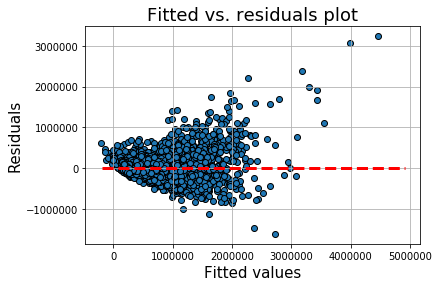

In [152]:
p=plt.scatter(x=model_int_features.fittedvalues,y=model_int_features.resid,edgecolor='k')
xmin=min(model_int_features.fittedvalues)
xmax = max(model_int_features.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

In [153]:
for i in range(len(X_train_int_features.columns)):
    v=vif(np.matrix(X_train_int_features),i)
    print("Variance inflation factor for {}: {}".format(X_train_int_features.columns[i],round(v,2)))

Variance inflation factor for bedrooms: 120.28
Variance inflation factor for bathrooms: 29.59
Variance inflation factor for sqft_living: 157.68
Variance inflation factor for sqft_lot: 6.5
Variance inflation factor for floors: 79.14
Variance inflation factor for grade: 109.98
Variance inflation factor for sqft_living15: 92.96
Variance inflation factor for sqft_lot15: 3.37
Variance inflation factor for view__1: 1.06
Variance inflation factor for view__2: 1.14
Variance inflation factor for view__3: 1.12
Variance inflation factor for view__4: 1.63
Variance inflation factor for waterfront__1: 1.54
Variance inflation factor for yr_updated_(1954.0, 1977.0]: 2.93
Variance inflation factor for yr_updated_(1977.0, 1999.0]: 4.1
Variance inflation factor for yr_updated_(1999.0, 2015.0]: 4.84
Variance inflation factor for condition_(3, 5]: 2.05
Variance inflation factor for zipcode_(98004.0, 98008.0]: 2.63
Variance inflation factor for zipcode_(98008.0, 98023.0]: 2.29
Variance inflation factor for 

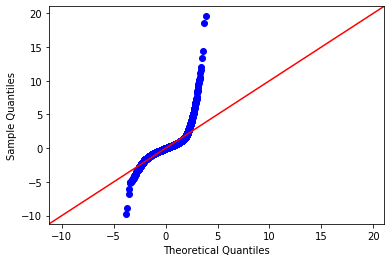

In [154]:
sm.graphics.qqplot(model_int_features.resid, line='45', fit=True);

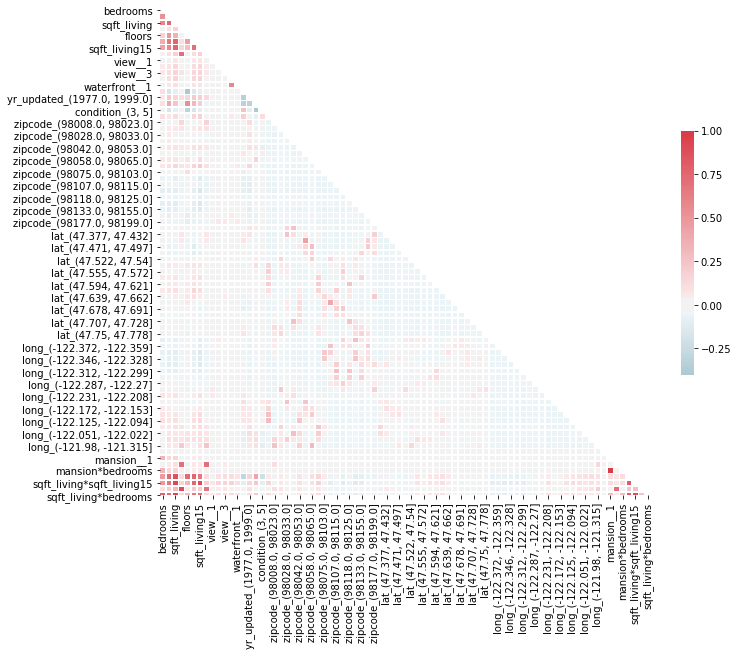

In [155]:
correlation_triangle(X_train_int_features)

In [156]:
X_train_int_features.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_living15,sqft_lot15,view__1,view__2,...,"long_(-122.022, -121.98]","long_(-121.98, -121.315]",season,mansion__1,lot*lot15,mansion*bedrooms,sqft_living*floors,sqft_living*sqft_living15,sqft_living*sqft_lot,sqft_living*bedrooms
bedrooms,1.000000,0.523910,0.596618,0.031095,0.185497,0.375128,0.421948,0.029993,0.028410,0.044224,...,0.025297,0.003763,0.001840,0.336616,0.003428,0.336616,0.482123,0.494017,0.092976,0.789840
bathrooms,0.523910,1.000000,0.753144,0.084917,0.505498,0.669702,0.575449,0.084743,0.039298,0.084369,...,0.110636,0.063141,0.015406,0.144971,0.049238,0.144971,0.747315,0.674018,0.190849,0.724815
sqft_living,0.596618,0.753144,1.000000,0.170428,0.355301,0.764176,0.758461,0.180175,0.069271,0.135314,...,0.084849,0.072522,0.012998,0.156595,0.085857,0.156595,0.869405,0.923589,0.301301,0.938830
sqft_lot,0.031095,0.084917,0.170428,1.000000,-0.006320,0.112753,0.142212,0.713182,-0.009199,0.036631,...,0.073642,0.213199,-0.005768,0.011257,0.707922,0.011257,0.122386,0.158632,0.886725,0.129187
floors,0.185497,0.505498,0.355301,-0.006320,1.000000,0.461112,0.284721,-0.016713,-0.024485,0.006211,...,0.111717,0.068723,0.013056,0.022971,0.014472,0.022971,0.728277,0.323247,0.056853,0.312671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mansion*bedrooms,0.336616,0.144971,0.156595,0.011257,0.022971,0.044639,0.055165,0.008603,-0.000347,0.021420,...,-0.013410,-0.013567,-0.012356,1.000000,0.004027,1.000000,0.124245,0.118105,0.034653,0.297454
sqft_living*floors,0.482123,0.747315,0.869405,0.122386,0.728277,0.753407,0.669449,0.123896,0.028854,0.095980,...,0.116868,0.091944,0.015154,0.124245,0.072648,0.124245,1.000000,0.819895,0.249594,0.811670
sqft_living*sqft_living15,0.494017,0.674018,0.923589,0.158632,0.323247,0.767032,0.897652,0.185847,0.071262,0.140020,...,0.099446,0.080860,0.015595,0.118105,0.068978,0.118105,0.819895,1.000000,0.276131,0.864778
sqft_living*sqft_lot,0.092976,0.190849,0.301301,0.886725,0.056853,0.219082,0.202458,0.686136,-0.005244,0.044390,...,0.082429,0.189956,-0.008203,0.034653,0.717641,0.034653,0.249594,0.276131,1.000000,0.253839


## Model with Polynomials

### Define Feature Sets

In [166]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated']
poly_cols = [col for col in X_train.columns if col not in cols_to_ignore]

X_train_poly_features = X_train[poly_cols]
X_test_poly_features = X_test[poly_cols]

**Features to Drop**

sqft_living had a high multicolinearity with sqft_above, and its residuals with the target were
not homoskedastic

**high multicolinearity**
* grade

**high p-values**
* lat_(47.31, 47.35]
* zipcode_(98038.0, 98042.0]
* sqft_basement
* long_(-122.208, -122.189]
* sqft_lot15
* lot*lot15


In [167]:
features_to_drop = ['sqft_above', 'lat_(47.31, 47.35]', 'zipcode_(98038.0, 98042.0]',
                     'sqft_basement', 'long_(-122.208, -122.189]', 'sqft_lot15',
                   'lot*lot15']
X_train_poly_features, X_test_poly_features = drop_features(X_train_poly_features, 
                                                             X_test_poly_features, 
                                                             features_to_drop)

### Add polynomials

In [168]:
poly = PolynomialFeatures(3)
X_train_poly_features_fin = poly.fit_transform(X_train_poly_features)
X_test_poly_features_fin = poly.fit_transform(X_test_poly_features)
poly_grade_train = poly.fit_transform(X_train_poly_features['grade'].values.reshape(-1, 1))
poly_grade_test = poly.fit_transform(X_test_poly_features['grade'].values.reshape(-1, 1))

In [169]:
X_train_poly_features['grade^2'] = poly_grade_train[:, 2]
X_test_poly_features['grade^2'] = poly_grade_test[:, 2]
X_train_poly_features['grade^3'] = poly_grade_train[:, 3]
X_test_poly_features['grade^3'] = poly_grade_test[:, 3]

### Linear Regression sklearn

In [170]:
lin_reg_sklearn(X_train_poly_features, X_test_poly_features, y_train, y_test)

Training Set RMSE: 160167.16647914244
Test Set RMSE: 161579.73374464447
Cross Val RMSE: 163032.85341758557


### Linear Regression statsmodels

In [171]:
model_poly_features = lin_reg_statsmodels(X_train_poly_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     924.5
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        19:37:17   Log-Likelihood:            -2.3088e+05
No. Observations:               17226   AIC:                         4.619e+05
Df Residuals:                   17147   BIC:                         4.625e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -1.438e+06   1.37e+05    -10.529      0.000   -1.71e+06   -1.17e+06
bedrooms                    -3.212e+04   4089.101     -7.854      0.000   -4.01e+04   -2.41e+04
bathrooms                    3.038e+04   2967.770     10.237      0.000    2.46e+04    3.62e+04
sqft_living                    17.8431      7.889      2.262      0.024       2.380      33.306
sqft_lot                        0.9567      0.067     14.204      0.000       0.825       1.089
floors                      -8.892e+04   7298.731    -12.183      0.000   -1.03e+05   -7.46e+04
grade                        7.228e+05   5.11e+04     14.146      0.000    6.23e+05    8.23e+05
sqft_living15                 -26.8394      6.107     -4.395      0.000     -38.810     -14.869
view__1                      9.685e+04   1.05e+04      9.227      0.000    7.63e+04    1.17e+05
view__2                      6.565e+04   6159.147     10.659      0.000    5.36e+04    7.77e+04
view__3                      1.421e+05   8542.093     16.637      0.000    1.25e+05    1.59e+05
view__4                      2.748e+05   1.28e+04     21.467      0.000     2.5e+05       3e+05
waterfront__1                5.843e+05   1.83e+04     31.972      0.000    5.48e+05     6.2e+05
yr_updated_(1954.0, 1977.0] -3.245e+04   4267.882     -7.604      0.000   -4.08e+04   -2.41e+04
yr_updated_(1977.0, 1999.0] -3.441e+04   5024.783     -6.849      0.000   -4.43e+04   -2.46e+04
yr_updated_(1999.0, 2015.0] -1.104e+04   5592.501     -1.975      0.048    -2.2e+04     -81.380
condition_(3, 5]             4.663e+04   3008.436     15.498      0.000    4.07e+04    5.25e+04
zipcode_(98004.0, 98008.0]  -1.555e+05   8835.533    -17.596      0.000   -1.73e+05   -1.38e+05
zipcode_(98008.0, 98023.0]  -1.143e+05   7606.512    -15.030      0.000   -1.29e+05   -9.94e+04
zipcode_(98023.0, 98028.0]  -1.315e+05   8999.937    -14.616      0.000   -1.49e+05   -1.14e+05
zipcode_(98028.0, 98033.0]  -1.272e+05   7430.850    -17.117      0.000   -1.42e+05   -1.13e+05
zipcode_(98033.0, 98038.0]   -9.51e+04   7948.155    -11.965      0.000   -1.11e+05   -7.95e+04
zipcode_(98042.0, 98053.0]   -1.46e+05   8512.907    -17.155      0.000   -1.63e+05   -1.29e+05
zipcode_(98053.0, 98058.0]  -1.711e+05   9137.878    -18.726      0.000   -1.89e+05   -1.53e+05
zipcode_(98058.0, 98065.0]  -1.247e+05   1.02e+04    -12.233      0.000   -1.45e+05   -1.05e+05
zipcode_(98065.0, 98075.0]  -2.382e+05   8169.786    -29.160      0.000   -2.54e+05   -2.22e+05
zipcode_(98075.0, 98103.0]  -1.001e+05   7658.973    -13.065      0.000   -1.15e+05   -8.51e+04
zipcode_(98103.0, 98107.0]  -1.321e+05   9927.000    -13.307      0.000   -1.52e+05   -1.13e+05
zipcode_(98107.0, 98115.0]  -7.084e+04   8986.424     -7.883      0.000   -8.85e+04   -5.32e+04
zipcode_(98

### Residuals

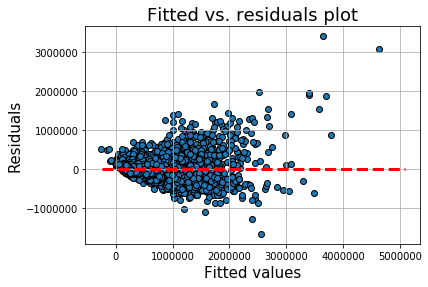

In [172]:
p=plt.scatter(x=model_poly_features.fittedvalues,y=model_poly_features.resid,edgecolor='k')
xmin=min(model_poly_features.fittedvalues)
xmax = max(model_poly_features.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()